In [ ]:
from qcportal import PortalClient
from openff.toolkit.topology import Molecule
from chargecraft.storage.qcarchive_transfer import QCArchiveToLocalDB
import numpy as np
import matplotlib.pyplot as plt
from chargecraft.storage.storage import MoleculePropStore, MoleculePropRecord
import pandas as pd
import json
from openff.units import unit
from openff.units import unit
import numpy as np
AU_ESP = unit.atomic_unit_of_energy / unit.elementary_charge


def assign_esp(monopoles : np.ndarray[float],
               dipoles : np.ndarray[float],
               quadropules : np.ndarray[float],
               grid: unit.Quantity,
               coordinates: unit.Quantity) -> list[float,float]:
    """Assign charges according to charge model selected

    Parameters
    ----------
    ob_mol: generic python object depending on the charge model
        Charge model appropriate python object on which to assign the charges

    Returns
    -------
    partial_charges: list of partial charges 
    """

    #multipoles with correct units
    monopoles_quantity = monopoles.to(unit.e)
    dipoles_quantity = dipoles.to(unit.e*unit.angstrom)
    quadropoles_quantity = quadropules.to(unit.e*unit.angstrom*unit.angstrom)
    coordinates_ang = coordinates.to(unit.angstrom)
    monopole_esp = calculate_esp_monopole_au(grid_coordinates=grid,
                                        atom_coordinates=coordinates_ang,
                                        charges = monopoles_quantity)
    dipole_esp = calculate_esp_dipole_au(grid_coordinates=grid,
                                    atom_coordinates=coordinates_ang,
                                    dipoles= dipoles_quantity)
    quadrupole_esp = calculate_esp_quadropole_au(grid_coordinates=grid,
                                    atom_coordinates=coordinates_ang,
                                    quadrupoles= quadropoles_quantity)
    #NOTE: ESP units, hartree/e and grid units are angstrom
    return (monopole_esp + dipole_esp + quadrupole_esp).m.flatten().tolist(), grid.m.tolist()


def calculate_esp_monopole_au(
    grid_coordinates: unit.Quantity,  # N x 3
    atom_coordinates: unit.Quantity,  # M x 3
    charges: unit.Quantity,  # M
    ):
    """Generate the esp from the on atom monopole
    
    Parameters
    ----------
    grid_coordinates: unit.Quantity
        grid on which to build the esp on 

    atom_coordinates: unit.Quantity
        coordinates of atoms to build the esp  
    
    charges: unit.Quantity
        monopole or charges

    Returns
    -------
    monopole_esp: unit.Quantity
        monopole esp
    """
    #prefactor
    ke = 1 / (4 * np.pi * unit.epsilon_0) # 1/vacuum_permittivity, 1/(e**2 * a0 *Eh)

    #Ensure everything is in AU and correct dimensions
    charges = charges.flatten()
    grid_coordinates = grid_coordinates.reshape((-1, 3)).to(unit.bohr)  #Å to Bohr
    atom_coordinates = atom_coordinates.reshape((-1, 3)).to(unit.bohr)    #Å to Bohr
    #displacement and distance
    displacement = grid_coordinates[:, None, :] - atom_coordinates[None, :, :]  # N x M x 3 B
    distance = np.linalg.norm(displacement.m, axis=-1)*unit.bohr # N, M
    inv_distance = 1 / distance  #N, M

    esp = ke*np.sum(inv_distance * charges[None,:], axis=1)  # (N,M)*(1,M) -> (N,M) numpy broadcasts all charges. Over all atoms  =  Sum over M (atoms), resulting shape: (N,) charges broadcast over each N
    # print('monopole esp')
    # print(esp)
    return esp.to(AU_ESP)

def calculate_esp_dipole_au(
    grid_coordinates: unit.Quantity,  # N , 3
    atom_coordinates: unit.Quantity,  # M , 3
    dipoles: unit.Quantity,  # M , 3       
    ) -> unit.Quantity:
    """Generate the esp from the on atom dipoles
    
    Parameters
    ----------
    grid_coordinates: unit.Quantity
        grid on which to build the esp on 

    atom_coordinates: unit.Quantity
        coordinates of atoms to build the esp  
    
    dipoles: unit.Quantity
        dipoles or charges

    Returns
    -------
    dipoles_esp: unit.Quantity
        monopole esp
    """

    #prefactor
    ke = 1 / (4 * np.pi * unit.epsilon_0) # 1/vacuum_permittivity, 1/(e**2 * a0 *Eh)

    #Ensure everything is in AU
    dipoles = dipoles.to(unit.e*unit.bohr)
    grid_coordinates = grid_coordinates.reshape((-1, 3)).to(unit.bohr)  #Å to Bohr
    atom_coordinates = atom_coordinates.reshape((-1, 3)).to(unit.bohr)    #Å to Bohr

    displacement = grid_coordinates[:, None, :] - atom_coordinates[None, :, :]  # N , M , 3 
    distance = np.linalg.norm(displacement.m, axis=-1)*unit.bohr # N, M 
    inv_distance_cubed = 1 / distance**3 #1/B
    #Hadamard product for element-wise multiplication
    dipole_dot = np.sum(displacement * dipoles[None,:,:], axis=-1) # dimless * e.a

    esp = ke*np.sum(inv_distance_cubed* dipole_dot,axis=1) # e.a/a**2 
    # print('dipole esp')
    # print(esp)
    return esp.to(AU_ESP)

def calculate_esp_quadropole_au(
    grid_coordinates: unit.Quantity,  # N x 3
    atom_coordinates: unit.Quantity,  # M x 3
    quadrupoles: unit.Quantity,  # M 3 3
    ) -> unit.Quantity:
    """Generate the esp from the on atom quandropoles
    
    Parameters
    ----------
    grid_coordinates: unit.Quantity
        grid on which to build the esp on 

    atom_coordinates: unit.Quantity
        coordinates of atoms to build the esp  
    
    quandropoles: unit.Quantity
        dipoles or charges

    Returns
    -------
    quandropoles_esp: unit.Quantity
        monopole esp
    """

    #prefactor
    ke = 1 / (4 * np.pi * unit.epsilon_0) # 1/vacuum_permittivity, 1/(e**2 * a0 *Eh)
    #Ensure everything is in AU
    quadrupoles = detrace(quadrupoles.to(unit.e*unit.bohr*unit.bohr))

    grid_coordinates = grid_coordinates.reshape((-1, 3)).to(unit.bohr)  #Å to Bohr
    atom_coordinates = atom_coordinates.reshape((-1, 3)).to(unit.bohr)    #Å to Bohr

    displacement = grid_coordinates[:, None, :] - atom_coordinates[None, :, :]  # N , M , 3 
    distance = np.linalg.norm(displacement.m, axis=-1)*unit.bohr # N, M 
    inv_distance = 1 / distance #1/B

    quadrupole_dot_1 = np.sum(quadrupoles[None,:,:] * displacement[:,:,None],axis=-1)
    quadrupole_dot_2 = np.sum(quadrupole_dot_1*displacement,axis=-1)
    esp = ke*np.sum((3*quadrupole_dot_2*(1/2 * inv_distance**5)),axis=-1)
    # print('quadrupole esp')
    # print(esp)
    return esp.to(AU_ESP)

def detrace(quadrupoles: unit.Quantity) -> unit.Quantity:

    #convert to numpy array
    quadrupoles = quadrupoles.m
    for i in range(quadrupoles.shape[0]):
        trace = np.trace(quadrupoles[i])
        trace /= 3
        # make sure we have the traceless quad tensor

        quadrupoles[i][0][0]=quadrupoles[i][0][0] - trace
        quadrupoles[i][0][1]=quadrupoles[i][0][1]
        quadrupoles[i][0][2]=quadrupoles[i][0][2]
        quadrupoles[i][1][1]=quadrupoles[i][1][1] - trace
        quadrupoles[i][2][2]=quadrupoles[i][2][2] - trace
        quadrupoles[i][1][2]=quadrupoles[i][1][2]

    #convert back to unit quantity
    quadrupoles = quadrupoles*unit.e*unit.bohr*unit.bohr
    return quadrupoles


In [4]:
prop_store = MoleculePropStore('/mnt/nfs/home/nca121/benchmark_db/wavefunction_correct_property/database.db')
ccsd_mols = prop_store.list()
ccsd_mols

['CC(=O)O',
 'COC',
 'CCO',
 'CC(C)=O',
 'CC(=O)[O-]',
 'c1ccccc1',
 'CC',
 'Oc1ccccc1',
 'c1ccsc1',
 'O=C1CCCN1',
 'C1CCOC1',
 '[S-]c1ccccc1',
 'CS(=O)(=O)[O-]',
 'CC(C)F',
 '[O-]c1ccsn1',
 'CP(=O)([O-])[O-]',
 'Fc1ccccc1',
 'COCC(F)(F)F',
 'Clc1cccnc1',
 'COC[B-](F)(F)F',
 'Clc1ccccc1',
 'Brc1cc[nH]c1',
 'CCOB(O)O']

In [6]:
prop_store_dft = MoleculePropStore('/mnt/storage/nobackup/nca121/QC_archive_review/benchmark_review/filter_dataset/benchmark_2.db')
wbx_list = prop_store_dft.list()
wbx_list

['CC(=O)O',
 'CO[Si](C)(C)O',
 'CP(=O)([O-])[O-]',
 'CC(C)=O',
 'CS(=O)(=O)[O-]',
 '[O-]c1ccsn1',
 '[S-]c1ccccc1',
 'CC',
 'CCO',
 'Clc1ccccc1',
 'CC(C)F',
 'c1ccsc1',
 'Fc1cccc(F)c1F',
 'C1CCNC1',
 'C1CC[NH2+]CC1',
 'O=C1CCCN1',
 'COC',
 'N#Cc1ccccc1',
 'Brc1cc[nH]c1',
 'C1CCOC1',
 'CCOB(O)O',
 'Nc1ccccc1',
 'Oc1ccccc1',
 'Clc1cccnc1',
 'Fc1ccccc1',
 'C[Si]1(C)CCCC1',
 'COCC(F)(F)F',
 'CC(=O)[O-]',
 'c1c[nH+]c[nH]1',
 'Cc1c[nH]c2ccccc12',
 'Brc1ccccc1',
 'c1ccccc1',
 'CCSC',
 'CCS',
 'COC[B-](F)(F)F',
 'Ic1ccccc1']

In [7]:
wb97x_def2tzvpp = prop_store_dft.retrieve(smiles='CC(=O)O', method='pbe0', basis='def2-tzvpp')[0]
wb97x_def2tzvpp

MoleculePropRecord(tagged_smiles='[C:1]([C:2]([O:3][H:4])=[O:5])([H:6])([H:7])[H:8]', conformer=array([[-0.95521381, -0.09210192,  0.02388881],
       [ 0.48344906,  0.25972435, -0.21507596],
       [ 1.30230613, -0.47195919,  0.53648588],
       [ 2.19276153, -0.21733363,  0.35332   ],
       [ 0.8808096 ,  1.0784583 , -0.96830412],
       [-1.11567325, -1.1407954 , -0.19485691],
       [-1.58728493,  0.51791522, -0.60235614],
       [-1.20115433,  0.06609226,  1.06689845]]), grid_coordinates=array([[-4.24264069, -0.70710678, -0.35355339],
       [-4.24264069, -0.70710678,  0.35355339],
       [-4.24264069, -0.35355339, -0.70710678],
       ...,
       [ 4.24264069,  0.70710678, -0.35355339],
       [ 4.24264069,  0.70710678,  0.35355339],
       [ 4.24264069,  0.70710678,  1.06066017]]), esp=array([[0.0068007 ],
       [0.00697193],
       [0.00663036],
       ...,
       [0.01262542],
       [0.01784221],
       [0.01700047]]), electric_field=array([[-1.53902482e-03, -1.44306287e-04

In [10]:
produced_esp = assign_esp(monopoles=wb97x_def2tzvpp.mbis_charges_quantity,
           dipoles=wb97x_def2tzvpp.mbis_dipole_quantity.reshape(-1,3),
           quadropules=wb97x_def2tzvpp.mbis_quadropole_quantity.reshape(-1,3,3),
           grid=wb97x_def2tzvpp.grid_coordinates_quantity,
           coordinates=wb97x_def2tzvpp.conformer_quantity)
produced_esp

([0.00609464335821529,
  0.006058590466524967,
  0.006170747548622413,
  0.006162948315199827,
  0.006129519636335981,
  0.0063395412895147175,
  0.0062043248755826235,
  0.00637121462349527,
  0.006336384091275652,
  0.006187253417684998,
  0.006150313021833875,
  0.006825225460565552,
  0.0067191607472713855,
  0.006756461175038363,
  0.006788723749731053,
  0.006636565729917987,
  0.006607352128814418,
  0.006781235936838855,
  0.006635740097270203,
  0.006676948877259366,
  0.0063868542291794774,
  0.006888240608902746,
  0.006673805978739261,
  0.0066527899130667005,
  0.006895175529583373,
  0.0070469204508237055,
  0.007019456804391368,
  0.006690327778292047,
  0.006917356543584786,
  0.006875438154527192,
  0.007535984835132896,
  0.007090705797346269,
  0.006900972628904631,
  0.00718553758925457,
  0.0076267099505177875,
  0.007701982240905656,
  0.007113044706861262,
  0.007089000533438791,
  0.006831376804720412,
  0.007858741301727827,
  0.007465831600689888,
  0.00699660

In [11]:
wb97x_def2tzvpp.mbis_quadropole.reshape(-1,3,3)

array([[[-5.42932611e+00, -2.17662453e-02,  1.49349741e-02],
        [-2.17662453e-02, -5.36099946e+00,  1.49871168e-02],
        [ 1.49349741e-02,  1.49871168e-02, -5.35704302e+00]],

       [[-3.06702530e+00, -4.11124632e-02,  1.97119379e-02],
        [-4.11124632e-02, -2.88280747e+00,  9.93386031e-02],
        [ 1.97119379e-02,  9.93386031e-02, -2.86893517e+00]],

       [[-4.36942351e+00,  1.48812700e-03,  2.56065258e-03],
        [ 1.48812700e-03, -4.43351373e+00,  3.21544165e-03],
        [ 2.56065258e-03,  3.21544165e-03, -4.43305694e+00]],

       [[-2.42753179e-01, -2.81887022e-03,  2.83492851e-03],
        [-2.81887022e-03, -2.40923823e-01, -4.10371117e-03],
        [ 2.83492851e-03, -4.10371117e-03, -2.40934773e-01]],

       [[-4.50638293e+00,  3.71911301e-03, -2.02029331e-02],
        [ 3.71911301e-03, -4.34886723e+00,  8.68617707e-02],
        [-2.02029331e-02,  8.68617707e-02, -4.34203340e+00]],

       [[-4.35172390e-01, -3.31324474e-03, -6.08535655e-05],
        [-3.31

In [12]:
wb97x_def2tzvpp.mbis_quadropole.reshape(-1,3,3)[0][0][0]

-5.429326112532647

In [13]:
np.mean(np.abs(np.array(produced_esp[0]) - wb97x_def2tzvpp.esp.flatten()), axis=0) * 627.509

0.28396816222791804

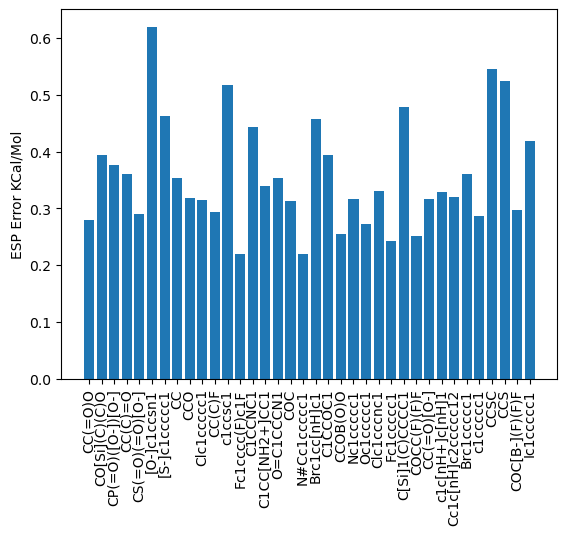

<Figure size 2000x1500 with 0 Axes>

In [9]:
esp_error = []
for mol in wbx_list:
    wb97x_def2tzvpp = prop_store_dft.retrieve(smiles=mol, method='wb97x-d', basis='def2-tzvpp')[0]
    produced_esp = assign_esp(monopoles=wb97x_def2tzvpp.mbis_charges_quantity,
        dipoles=wb97x_def2tzvpp.mbis_dipole_quantity.reshape(-1,3),
        quadropules=wb97x_def2tzvpp.mbis_quadropole_quantity.reshape(-1,3,3),
        grid=wb97x_def2tzvpp.grid_coordinates_quantity,
        coordinates=wb97x_def2tzvpp.conformer_quantity)
    rebult_esp = np.mean(np.abs(np.array(produced_esp[0]) - wb97x_def2tzvpp.esp.flatten()), axis=0) * 627.509
    esp_error.append(rebult_esp)

plt.bar(x=wbx_list, height=esp_error)
plt.ylabel('ESP Error KCal/Mol')
plt.xticks(rotation = 90)
plt.figure(figsize=(20,15))
plt.savefig('esp_from_mbis.png')
plt.show()

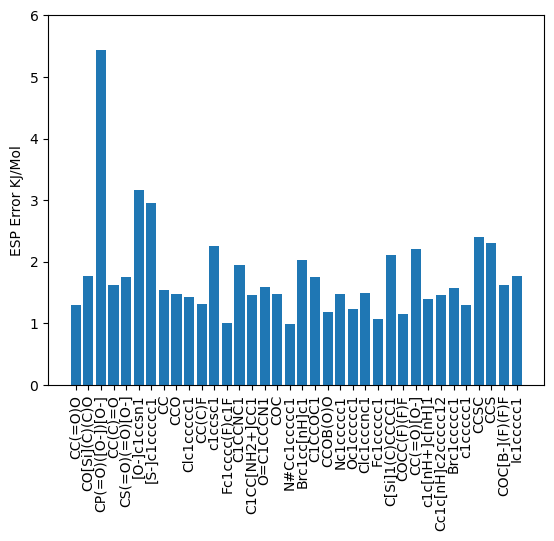

<Figure size 2000x1500 with 0 Axes>

In [23]:
esp_error = []
for mol in wbx_list:
    wb97x_def2tzvpp = prop_store_dft.retrieve(smiles=mol, method='pbe0', basis='def2-tzvppd')[0]
    produced_esp = assign_esp(monopoles=wb97x_def2tzvpp.mbis_charges_quantity,
        dipoles=wb97x_def2tzvpp.mbis_dipole_quantity.reshape(-1,3),
        quadropules=wb97x_def2tzvpp.mbis_quadropole_quantity.reshape(-1,3,3),
        grid=wb97x_def2tzvpp.grid_coordinates_quantity,
        coordinates=wb97x_def2tzvpp.conformer_quantity)
    rebult_esp = np.mean(np.abs(np.array(produced_esp[0]) - wb97x_def2tzvpp.esp.flatten()), axis=0) *  2625
    esp_error.append(rebult_esp)

plt.bar(x=wbx_list, height=esp_error)
plt.ylabel('ESP Error KJ/Mol')
plt.xticks(rotation = 90)
plt.ylim(0,6)
plt.figure(figsize=(20,15))
plt.show()

In [30]:
def esp_to_electric_field( esp: np.ndarray, grid: unit.Quantity) -> np.ndarray:
    """
    Convert ESP to electric field by computing the gradient.

    Parameters
    ----------
    esp : np.ndarray
        Electrostatic potential values.
    grid : unit.Quantity
        Grid coordinates.

    Returns
    -------
    electric_field : np.ndarray
        Electric field values.
    """
    grid = grid.m
    grid_spacing = np.array([np.diff(grid[:, i]).mean() for i in range(3)])  # Assuming uniform grid spacing
    print(grid_spacing)
    grad_x, grad_y, grad_z = np.gradient(esp, *grid_spacing)
    electric_field = -np.array([grad_x, grad_y, grad_z])
    return electric_field * (unit.hartree / unit.e / unit.bohr)  # Convert to appropriate units


In [26]:
np.diff(wb97x_def2tzvpp.grid_coordinates_quantity, axis=0).mean(axis=0)

Magnitude,[0.003818869375746161 0.0011087040123134036 0.00024637866940297815]
Units,angstrom


In [31]:
esp_to_electric_field(produced_esp[0], grid=wb97x_def2tzvpp.grid_coordinates_quantity)

[0.00381887 0.0011087  0.00024638]


TypeError: invalid number of arguments